# Getting The Data

In [1]:
import os
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive, check_integrity
from torchvision.datasets.folder import default_loader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from google.colab import drive

ModuleNotFoundError: No module named 'google'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
torch.manual_seed(0)

class EuroSat(ImageFolder):
  """Data Class"""
  def __init__(self, root='data', transform=None, target_transform=None):
    self.download(root)
    root = './data/2750/'
    super().__init__(root, transform=transform, target_transform=target_transform)

  @staticmethod
  def download(root):
    """Downloads and Extracts the Data"""
    if not check_integrity(os.path.join(root, "EuroSAT.zip")):
      download_and_extract_archive('http://madm.dfki.de/files/sentinel/EuroSAT.zip',
                                   root)

class ImageFiles(Dataset):
  """DataLoader"""
  def __init__(self, paths, loader=default_loader, transform=None):
    self.paths = paths
    self.loader = loader
    self.transform = transform

  def __getitem__(self,id):
    """Overwrite get item method"""
    image = self.loader(self.paths[id])
    if self.transform is not None:
      image = self.transform(image)
    return image, -1

  def __len__(self):
    """Overwrite get len method"""
    return len(self.paths)

def random_split(dataset, ratio=0.9):
  """Splits training and testing data"""
  split_size = int(len(dataset) * ratio)
  split = torch.utils.data.random_split(dataset, [split_size, len(dataset) - split_size])
  return split

In [ ]:
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
           'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
           'River', 'SeaLake']

### Define The Data Transform

In [ ]:
transform = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
    ]
)

## Download and get Dataset

In [ ]:
dataset = EuroSat(transform=transform)

Extracting data/EuroSAT.zip to data


## Train Test Split

In [ ]:
train, test = random_split(dataset, 0.8)

## Data Loading Parameters

In [ ]:
batch_size = 32
shuffle = True
num_workers = 4
pin_memory = True

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                           shuffle=shuffle, 
                                           num_workers=num_workers, 
                                           pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                           shuffle=shuffle, 
                                           num_workers=num_workers, 
                                           pin_memory=pin_memory)

In [ ]:
def normalize_bands(train_dl):
    mean = torch.zeros(3)
    m2 = torch.zeros(3)
    n = len(train_dl)
    for images, labels in tqdm(train_dl, "Computing Normalization"):
    
      mean += images.mean([0, 2, 3]) / n
      m2 += (images ** 2).mean([0, 2, 3]) / n

    var = m2 - mean ** 2
    return mean, var.sqrt()

mean, std = normalize_bands(train_loader)
dataset.transform.transforms.append(transforms.Normalize(mean,std))

Computing Normalization: 100%|██████████| 675/675 [00:20<00:00, 32.97it/s]


# Defining Our Models

In [ ]:
def conv_output_shape(input_shape, kernel_size, padding, stride):
  """Calculates the output of a convalutional layer"""
  return ((input_shape-kernel_size + 2*padding)/stride)+1

def max_pool_shape(height, width, kernel_size, padding=0, stride=-1, dilation=1):
  """calculates the output size of max pool  layer"""
  if stride == -1:
    stride = kernel_size
  h_n = (height + 2*padding - dilation * (kernel_size -1) -1)//stride + 1
  w_n = (width + 2*padding - dilation * (kernel_size -1) -1)//stride + 1
  return [h_n, w_n]

In [ ]:
print(conv_output_shape(np.array([64,64]), kernel_size=5, padding=1, stride=1))
print(max_pool_shape(62,62, kernel_size=2, stride=2))
print(conv_output_shape(np.array([31,31]), kernel_size=3, padding=1, stride=1))
print(max_pool_shape(31,31, kernel_size=2, stride=2))
print(conv_output_shape(np.array([15,15]), kernel_size=5, padding=1, stride=1))

[62. 62.]
[31, 31]
[31. 31.]
[15, 15]
[13. 13.]


## Standard CNN

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.name = 'cnn.pt'

        self.cnn_layers = nn.Sequential(
          nn.BatchNorm2d(3),
          nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1), # 62 x 62
          nn.ReLU(inplace=True),      
          nn.MaxPool2d(kernel_size=2, stride = 2), # 31 x 31
          nn.Dropout2d(0.1, inplace=True),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True), # 31 x 31
          nn.MaxPool2d(kernel_size=2, stride = 2),
          nn.Conv2d(64, 128, kernel_size=5, padding=1, stride=1),
          nn.Dropout2d(0.1, inplace=True),
          nn.ReLU(inplace=True)
      )

        self.linear_layers = nn.Sequential(
          nn.Linear(13*13*128, 256),
          nn.ReLU(inplace=True),
          nn.Linear(256,128),
          nn.ReLU(inplace=True),
          nn.Linear(128, 64),
          nn.ReLU(inplace=True),
          nn.Linear(64, 10),
      )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

## ResNET

In [ ]:
class Block(nn.Module):
    def __init__(
        self, n_in, n_out, iden_downsample=None, stride=1
    ):
        super(Block, self).__init__()
        self.expansion = 4
        self.cnn_layers = nn.Sequential(
          nn.Conv2d(n_in, n_out, kernel_size=1, stride=1, padding=0),
          nn.BatchNorm2d(n_out),
          nn.ReLU(inplace=True),
          nn.Conv2d(n_out, n_out, kernel_size=3, stride=stride, padding=1),
          nn.BatchNorm2d(n_out),
          nn.ReLU(inplace=True),
          nn.Conv2d(n_out, n_out * self.expansion, kernel_size=1, stride=1,
                    padding=0),
          nn.BatchNorm2d(n_out * self.expansion),
        )
        self.relu = nn.ReLU()
        self.iden_downsample = iden_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.cnn_layers(x)
        if self.iden_downsample is not None:
            identity = self.iden_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.name = 'Resnet.pt'

        self.cnn_layers = nn.Sequential(
          nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.residual_layers = nn.Sequential(
          self.create_layer(block, layers[0], inter_chan=64, stride=1),
          self.create_layer(block, layers[1], inter_chan=128, stride=2),
          self.create_layer(block, layers[2], inter_chan=256, stride=2),
          self.create_layer(block, layers[3], inter_chan=512, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.residual_layers(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def create_layer(self, Block, num_residual_Blocks, inter_chan, stride):
        iden_downsample = None
        layers = []

        if stride != 1 or self.in_channels != inter_chan * 4:
            iden_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, inter_chan * 4,
                    kernel_size=1, stride=stride,
                ),
                nn.BatchNorm2d(inter_chan * 4),
            )

        layers.append(
            Block(self.in_channels, inter_chan, iden_downsample, stride)
        )

        self.in_channels = inter_chan * 4

        for i in range(num_residual_Blocks - 1):
            layers.append(Block(self.in_channels, inter_chan))

        return nn.Sequential(*layers)

In [ ]:
# Resnet 50
net = ResNet(Block, [3, 4, 6, 3], 3, 10).to(device)
# Resnet 101
# net = ResNet(Block, [3, 4, 23, 3], 3, 10).to(device)
# Resnet 152
# net = ResNet(Block, [3, 8, 36, 3], 3, 10).to(device)
# print(net)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
%%time
net.train()
epoch_loss = []
number_of_epochs = 20
for epoch in trange(number_of_epochs, desc='Epoch'):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):

    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad() # zero the parameter gradients
    outputs = net(inputs) 
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  epoch_loss.append(running_loss)

print('finished')

Epoch: 100%|██████████| 20/20 [17:46<00:00, 53.32s/it]

finished
CPU times: user 16min 29s, sys: 1min 19s, total: 17min 48s
Wall time: 17min 46s


Text(0, 0.5, 'Running loss')

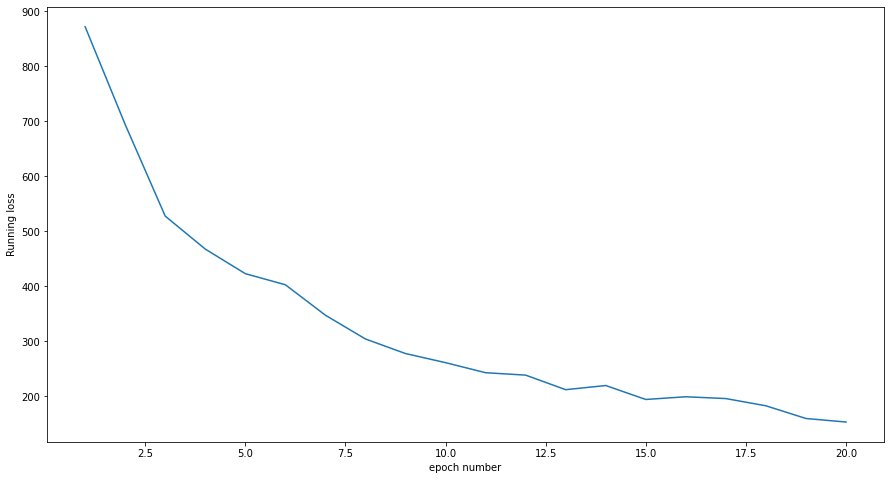

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,number_of_epochs + 1), epoch_loss)
plt.xlabel('epoch number')
plt.ylabel('Running loss')

# Testing The Model

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of AnnualCrop : 87 %
Accuracy of Forest : 95 %
Accuracy of HerbaceousVegetation : 94 %
Accuracy of Highway : 86 %
Accuracy of Industrial : 96 %
Accuracy of Pasture : 83 %
Accuracy of PermanentCrop : 86 %
Accuracy of Residential : 97 %
Accuracy of River : 91 %
Accuracy of SeaLake : 98 %
